# Models
Temperature: <br>
$$
\frac{dT}{dt} = \mathcal{P}(F_{AC}T_{AC} - F_{AC}T) + \mathcal{Q}(F_ET_E - F_eT) - \mathcal{X}\mathcal{R}k_L(C_{GC}K_{des} - C_{GS})\Delta H_{des}
$$
Concentration - Gold-on-carbon:
$$
\frac{dC_{GC}}{dt} = \mathcal{Y}C_{GC,i}F_{AC} - \mathcal{Y}C_{GC}F_{AC} - \mathcal{X}\mathcal{Y}k_L(C_{GC}K_{des} - C_{GS})
$$
Concentration - Gold-in-solution (not modelled)
$$
C_{GS} = \frac{(C_{GC,i} - C_{GC})(1 - \epsilon)}{\epsilon}
$$
<br>

$\Delta H_{des}$ chosen as:
$$
\Delta H_{des} = 7000\ \text{kJ/mol}
$$
$K_{des}$ chosen as:
$$
K_{des} = 15.3
$$
$k_L$ chosen as:
$$
k_L = 2\times 10^{-7}\ \text{m/min}
$$
Gold-loading is 2500 g/t.

# Elution behaviour without step changes in input variables

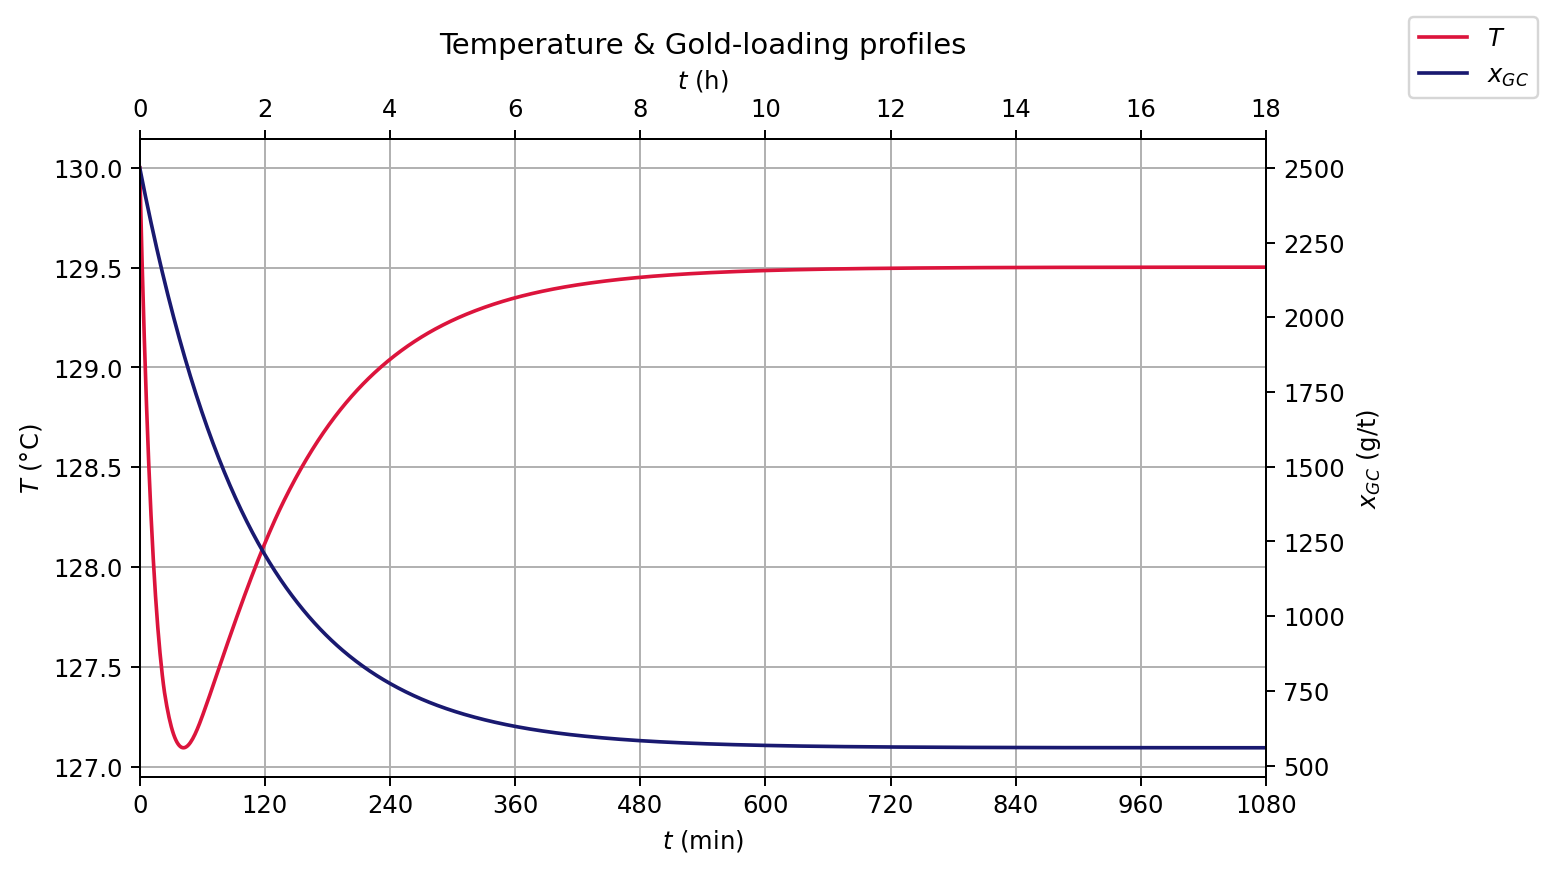

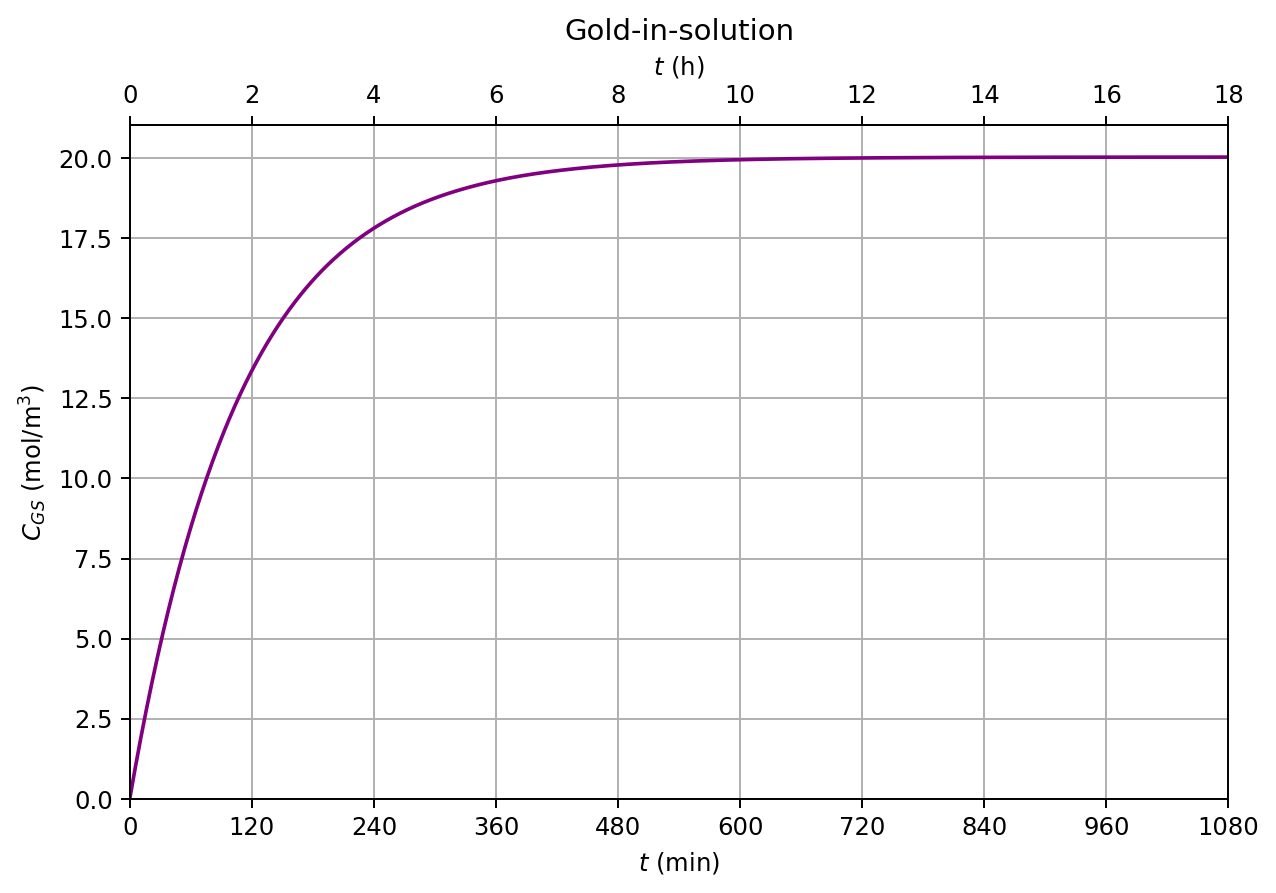

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

########### Column and material properties ############

d = 1 # diameter (m)
h = 10*d # column height (m) 
A_cs = np.pi/4*d**2 # cross-sectional area (m^2)
h_outlet = 0.95*h # height until liquid outlet at the top (m)
V = A_cs*h_outlet # volume available to solid & liquid (m^3)
t_res = 18 # residence time (h)
epsilon = 0.292 # void fraction, 0.25 < epsilon < 0.50
BV_per_h = (1 - epsilon)*V/1 # m^3.h^-1
d_p = 1.82e-3 # particle diameter (m)
rho_AC = 838.8 # kg.m^-3
rho_E = 938.93 # kg.m^-3
cp_AC = 0.925 # kJ.kg^-1.K^-1
cp_E = 4.25 # kJ.kg^-1.K^-1
gamma = 1 # shape factor, spherical = 1

########### Known parameters #############
P = 0.061 # m^-3
Q = 0.312 # m^-3
R = 7.818E-5 # K.kJ^-1
X = 1.23E4 # m^2
Y = 0.189 # m^-3
T_AC = 383.15 # K
T_E = 403.15 # K
Delta_H_des = 7000 # kJ.mol^-1 
MW_G = 196.97 # g/mol
rho_AC = 838.8 # kg/m^3
epsilon = 0.292
Gold_loading = 2500 # g/t

########### Calculated parameters #############
x_GCi = Gold_loading/1000
n_GCi = x_GCi/MW_G
C_GCi = n_GCi*rho_AC
F_AC = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
oper_flow_rate = 2*BV_per_h/60 # BV.min^-1 
F_E = oper_flow_rate # m^3.min^-1
F_E = 0.18
F_e = F_E
k_L = 2e-7 # m/min

def dS_dt(t, S):
    T, C_GC = S

    K_des = 15.3

    # Define equations
    C_GS = (C_GCi-C_GC)*(1 - epsilon)/epsilon
    equation_1 = P*(F_AC*T_AC - F_AC*T) + Q*(F_E*T_E - F_e*T) - X*R*k_L*(C_GC*K_des - C_GS)*Delta_H_des
    equation_2 = Y*C_GCi*F_AC - Y*C_GC*F_AC - X*Y*k_L*(C_GC*K_des - C_GS)

    return [equation_1,  equation_2]

# Initial values
T0 = 403.15 # K 
C_GC0 = C_GCi # mol/m^3
S0 = (T0, C_GC0)

t_span = (0, 1080)
t_eval = np.linspace(0, 1080, 1000)

solutions = solve_ivp(dS_dt, t_span = t_span, y0 = S0, t_eval = t_eval, method = 'Radau')

T = solutions.y[0]
C_GC = solutions.y[1]
n_GC_f = C_GC/rho_AC # mol Au/kg AC
x_GC_f = n_GC_f*MW_G*1000 # g Au/ton AC
C_GS = []

C_GS.append((C_GCi-C_GC)*(1 - epsilon)/epsilon)
C_GS = np.transpose(C_GS)

T_celcius = T - 273.15

t = t_eval

fig, ax1 = plt.subplots(figsize=(8.1, 5), dpi=175)

ax1.plot(t, T_celcius, color = 'crimson', label = r'$T$')
ax1.set_xlabel(r'$t$ (min)')
ax1.set_ylabel(r'$T$ ($\degree$C)')
x_ticks = [q*120 for q in range(10)]
ax1.set_xticks(ticks = x_ticks)
ax1.set_xlim([0, 1080])
ax1.grid(True)
ax1.set_title('Temperature & Gold-loading profiles')

ax2 = ax1.twinx()
ax2.plot(t, x_GC_f, color = 'midnightblue', label = r'$x_{GC}$')
ax2.set_ylabel(r'$x_{GC}$ (g/t)')

def min_to_h(x):
    return x / 60

def h_to_min(x):
    return x * 60

second_x = ax1.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2 = [q*2 for q in range(19)]
second_x.set_xticks(x_ticks_2)
second_x.set_xlabel(r'$t$ (h)')
second_x.set_xlim([0, 18])

fig.legend(bbox_to_anchor = (1.1, 1))
plt.tight_layout(h_pad=20.0)
plt.show()

fig, ax3 = plt.subplots(figsize=(8.1, 5), dpi=175)
ax3.plot(t, C_GS, color = 'purple')
ax3.set_ylim(0)
ax3.set_xlim([0, 18])
ax3.set_xlabel(r'$t$ (min)')
ax3.set_ylabel(r'$C_{GS}$ (mol/m$^3$)')
x_ticks = [q*120 for q in range(10)]
ax3.set_xticks(ticks = x_ticks)

second_x = ax3.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2 = [q*2 for q in range(19)]
second_x.set_xticks(x_ticks_2)
second_x.set_xlabel(r'$t$ (h)')
second_x.set_xlim([0, 18])

ax3.grid(True)
ax3.set_title('Gold-in-solution')
plt.show()

# Elution behaviour with steps in manipulated variables:
Manipulated variables:
$$
F_E
$$
$$
F_{AC}
$$
Process variables:
$$
T
$$
$$
C_{GC}\ \text{(Converted to g/t via stoichiometry)}
$$
Input variables (disturbances):
$$
T_{AC}
$$
$$
T_E
$$

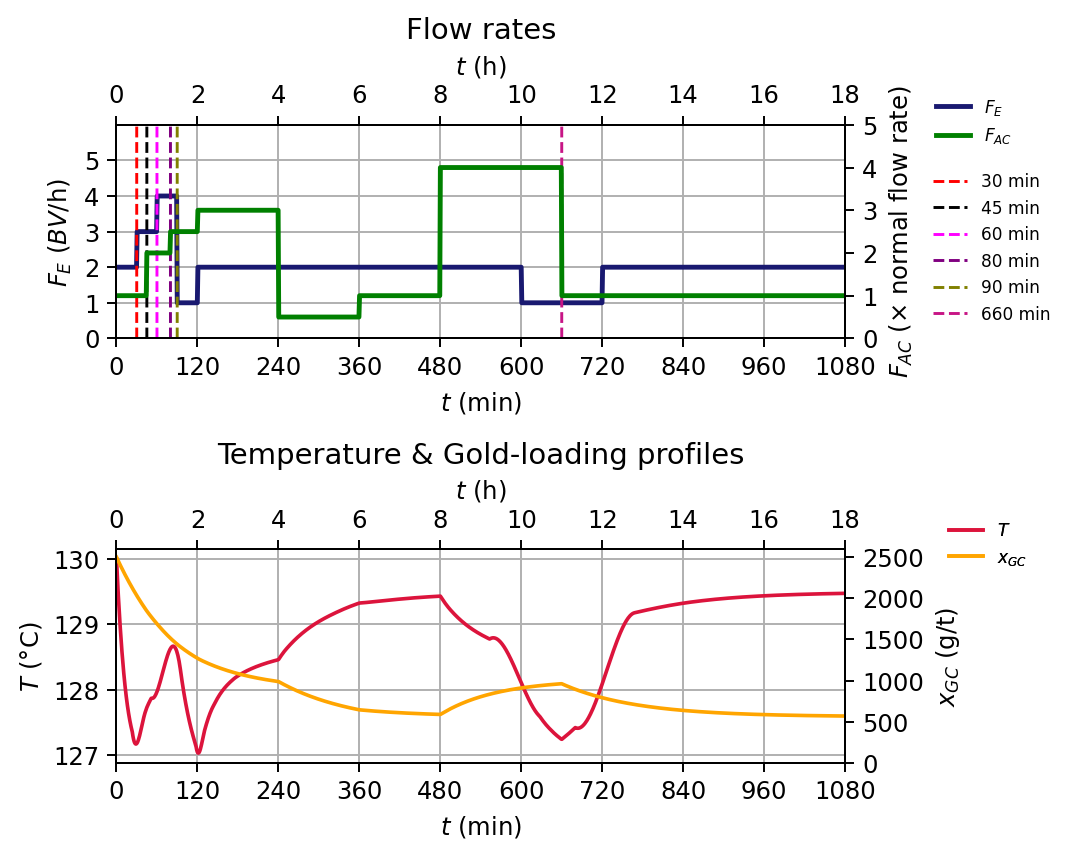

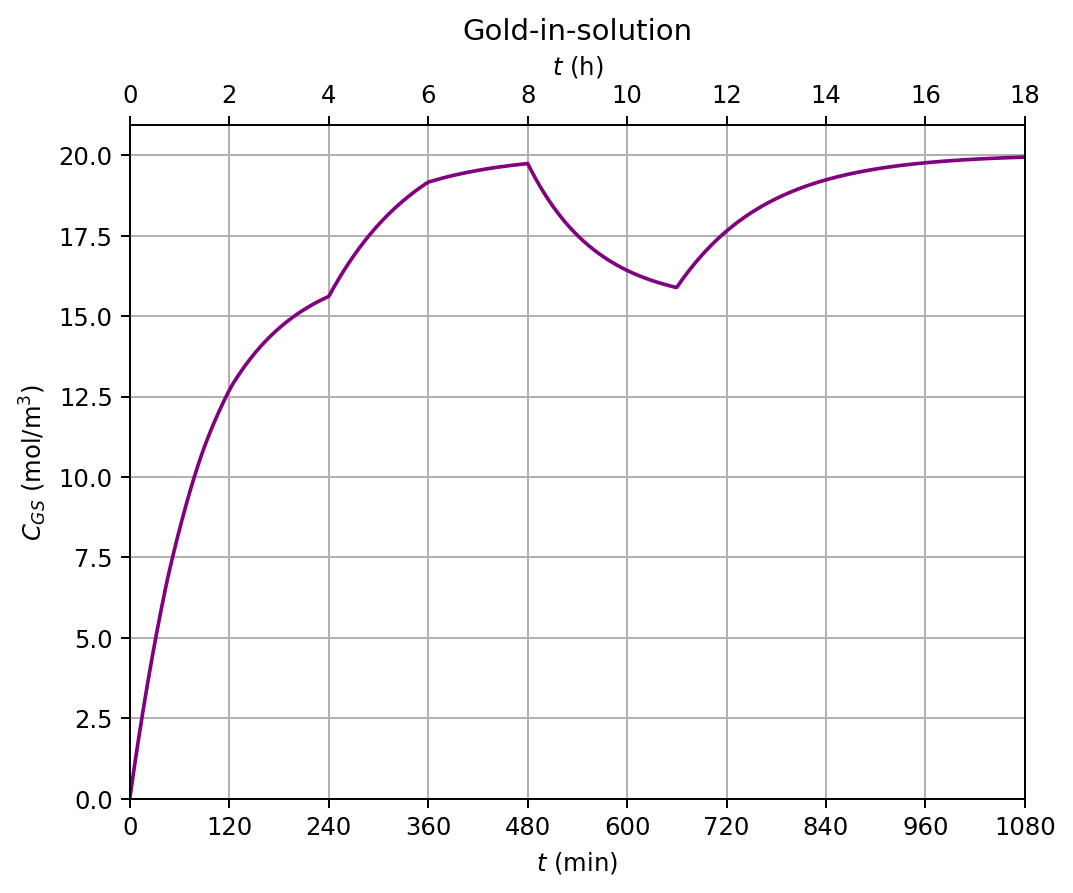

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

########### Column and material properties ############

d = 1 # diameter (m)
h = 10*d # column height (m) 
A_cs = np.pi/4*d**2 # cross-sectional area (m^2)
h_outlet = 0.95*h # height until liquid outlet at the top (m)
V = A_cs*h_outlet # volume available to solid & liquid (m^3)
t_res = 18 # residence time (h)
epsilon = 0.292 # void fraction, 0.25 < epsilon < 0.50
BV_per_h = (1 - epsilon)*V/1 # m^3.h^-1
d_p = 1.82e-3 # particle diameter (m)
rho_AC = 838.8 # kg.m^-3
rho_E = 938.93 # kg.m^-3
cp_AC = 0.925 # kJ.kg^-1.K^-1
cp_E = 4.25 # kJ.kg^-1.K^-1
gamma = 1 # shape factor, spherical = 1

########### Known parameters #############
P = 0.061 # m^-3
Q = 0.312 # m^-3
R = 7.818E-5 # K.kJ^-1
X = 1.23E4 # m^2
Y = 0.189 # m^-3
Z = 0.459 # m^-3
T_AC = 383.15 # K
T_E = 403.15 # K
Delta_H_des = 7000 # kJ.mol^-1 
MW_G = 196.97 # g/mol
rho_AC = 838.8 # kg/m^3
epsilon = 0.292
Gold_loading = 2500 # g/t
k_L = 2e-7 # m/min

########### Calculated parameters #############
x_GCi = Gold_loading/1000
n_GCi = x_GCi/MW_G
C_GCi = n_GCi*rho_AC

def dS_dt(t, S):
    T, C_GC = S

    K_des = 15.3
    F_AC = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
    multiplier = 0
    if t >= 30 and t < 60:
        multiplier = 3
    elif t >= 60 and t < 90:
        multiplier = 4
    elif t >= 90 and t < 120:
        multiplier = 1
    elif t >= 600 and t < 720:
        multiplier = 1
    else:
        multiplier = 2
    if t >= 45 and t < 80:
        F_AC = 2*F_AC
    elif t >= 80 and t < 120:
        F_AC = 2.5*F_AC
    elif t >= 120 and t < 240:
        F_AC = 3*F_AC
    elif t >= 240 and t < 360:
        F_AC = 0.5*F_AC
    elif t >= 480 and t < 660:
        F_AC = 4*F_AC
    else:
        F_AC = F_AC
    
    oper_flow_rate = multiplier*BV_per_h/60 # BV.min^-1
    F_E = oper_flow_rate # m^3.min^-1
    F_e = F_E

    # Define equations
    C_GS = (C_GCi-C_GC)*(1 - epsilon)/epsilon
    equation_1 = P*(F_AC*T_AC - F_AC*T) + Q*(F_E*T_E - F_e*T) - X*R*k_L*(C_GC*K_des - C_GS)*Delta_H_des
    equation_2 = Y*C_GCi*F_AC - Y*C_GC*F_AC - X*Y*k_L*(C_GC*K_des - C_GS)

    return [equation_1,  equation_2]

# Initial values
T0 = 403.15 # K 
C_GC0 = C_GCi # mol/m^3
C_GS0 = 0 # mol/m^3
S0 = (T0, C_GC0)

t_span = (0, 1080)
t_eval = np.linspace(0, 1080, 1200)

solutions = solve_ivp(dS_dt, t_span = t_span, y0 = S0, t_eval = t_eval, method = 'Radau')

T = solutions.y[0]
C_GC = solutions.y[1]
n_GC_f = C_GC/rho_AC # mol Au/kg AC
x_GC_f = n_GC_f*MW_G*1000 # g Au/ton AC
C_GS = []

C_GS.append((C_GCi-C_GC)*(1 - epsilon)/epsilon)
C_GS = np.transpose(C_GS)

T_celcius = T - 273.15

# First plot: Flow rates vs time

time = np.linspace(0, 1080, len(t_eval))
BV = np.zeros(len(time))
AC_flow = np.zeros(len(time))
p = 0
for t in time:
    if t >= 30 and t < 60:
        BV[p] = 3
    elif t >= 60 and t < 90:
        BV[p] = 4
    elif t >= 90 and t < 120:
        BV[p] = 1
    elif t >= 600 and t < 720:
        BV[p] = 1
    else:
        BV[p] = 2

    if t >= 45 and t < 80:
        AC_flow[p] = 2
    elif t >= 80 and t < 120:
        AC_flow[p] = 2.5
    elif t >= 120 and t < 240:
        AC_flow[p] = 3
    elif t >= 240 and t < 360:
        AC_flow[p] = 0.5
    elif t >= 480 and t < 660:
        AC_flow[p] = 4 
    else:
        AC_flow[p] = 1
    p += 1

fig, (ax1, ax3) = plt.subplots(2,1, figsize=(6.1, 5), dpi = 175)
fig.subplots_adjust(left = 2.5, right = 2.95)

label_1, = ax1.plot(time, BV, color = 'midnightblue', label = r'$F_E$', lw = 2)
vert_30 = np.linspace(0, 6, len(time))
time_30 = [30 for t in time]
vert_45 = np.linspace(0, 6, len(time))
time_45 = [45 for t in time]
vert_60 = np.linspace(0, 6, len(time))
time_60 = [60 for t in time]
vert_80 = np.linspace(0, 6, len(time))
time_80 = [80 for t in time]
vert_90 = np.linspace(0, 6, len(time))
time_90 = [90 for t in time]
vert_660 = np.linspace(0, 6, len(time))
time_660 = [660 for t in time]
line_width = 1.2
label_2, = ax1.plot(time_30, vert_30, color = 'red', ls = '--', lw = line_width, label = '30 min')
label_3, = ax1.plot(time_45, vert_45, color = 'black', ls = '--', lw = line_width, label = '45 min')
label_4, = ax1.plot(time_60, vert_60, color = 'fuchsia', ls = '--', lw = line_width, label = '60 min')
label_5, = ax1.plot(time_80, vert_80, color = 'purple', ls = '--', lw = line_width, label = '80 min')
label_6, = ax1.plot(time_90, vert_90, color = 'olive', ls = '--', lw = line_width, label = '90 min')
lable_10, = ax1.plot(time_660, vert_660, color = 'mediumvioletred', ls = '--', lw = line_width, label = '660 min')
ax1.set_ylim([0, 6])
ax1.set_xlabel(r'$t$ (min)')
ax1.set_ylabel(r'$F_E\ (BV$/h)')
x_ticks = [q*120 for q in range(10)]
ax1.set_xticks(ticks = x_ticks)
y_ticks = [q for q in range(6)]
ax1.set_yticks(ticks = y_ticks)
ax1.set_xlim([0, 1080])
ax1.grid(True)
ax1.set_title('Flow rates')

ax2 = ax1.twinx()
label_7, = ax2.plot(time, AC_flow, color = 'green', label = r'$F_{AC}$', lw = 2)
ax2.set_ylabel(r'$F_{AC}$ ($\times$ normal flow rate)')
y_ticks = [q for q in range(6)]
ax2.set_yticks(ticks = y_ticks)

def min_to_h(x):
    return x / 60

def h_to_min(x):
    return x * 60

second_x = ax1.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2 = [q*2 for q in range(19)]
second_x.set_xticks(x_ticks_2)
second_x.set_xlabel(r'$t$ (h)')
second_x.set_xlim([0, 18])

handle_1 = [label_1, label_7]
handle_2 = [label_2, label_3, label_4, label_5, label_6, lable_10]
legend_1 = ax1.legend(handles = handle_1, loc = 'upper right', bbox_to_anchor = (1.25, 1.2), frameon = False, fontsize = 7)
legend_2 = ax1.legend(handles = handle_2, loc = 'lower left', bbox_to_anchor = (1.1, 0), frameon = False, fontsize = 7)
ax1.add_artist(legend_1)
# Second plot: Temperature & x_GC vs time

label_8, = ax3.plot(time, T_celcius, color = 'crimson', label = r'$T$')
ax3.set_xlabel(r'$t$ (min)')
ax3.set_ylabel(r'$T$ ($\degree$C)')
x_ticks = [q*120 for q in range(10)]
ax3.set_xticks(ticks = x_ticks)
ax3.set_xlim([0, 1080])
ax3.grid(True)
ax3.set_title('Temperature & Gold-loading profiles')

ax4 = ax3.twinx()
label_9, = ax4.plot(time, x_GC_f, color = 'orange', label = r'$x_{GC}$')
ax4.set_ylabel(r'$x_{GC}$ (g/t)')
y_ticks = [q*500 for q in range(6)]
ax4.set_yticks(ticks = y_ticks)

second_x = ax3.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2 = [q*2 for q in range(19)]
second_x.set_xticks(x_ticks_2)
second_x.set_xlabel(r'$t$ (h)')
second_x.set_xlim([0, 18])

handle_3 = [label_8, label_9]
legend_3 = ax3.legend(handles = handle_3, loc = 'upper right', bbox_to_anchor = (1.27, 1.2), frameon = False, fontsize = 7)
ax3.add_artist(legend_3)


plt.tight_layout()
plt.show()

fig, ax5 = plt.subplots(figsize=(6.6, 5), dpi=175)
ax5.plot(time, C_GS, color = 'purple')
ax5.set_ylim(0)
ax5.set_xlim([0, 18])
ax5.set_xlabel(r'$t$ (min)')
ax5.set_ylabel(r'$C_{GS}$ (mol/m$^3$)')
x_ticks = [q*120 for q in range(10)]
ax5.set_xticks(ticks = x_ticks)

second_x = ax5.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2 = [q*2 for q in range(19)]
second_x.set_xticks(x_ticks_2)
second_x.set_xlabel(r'$t$ (h)')
second_x.set_xlim([0, 18])

ax5.grid(True)
ax5.set_title('Gold-in-solution')
plt.show()

# Regression analysis to find steady state values & matrix coefficients:
Unknowns:
$$
\bar{T}
$$
$$
\bar{C}_{GC}
$$
Matrix coefficients solved after finding $\bar{T}$ & $\bar{C}_{GC}$
$$
\begin{align}
a_{11}, a_{12}, a_{21}, a_{22} \\[2ex]
b_{11}, b_{12}, b_{21}, b_{22} \\[2ex]
e_{11}, e_{12}, e_{21}, e_{22}
\end{align}
$$

In [3]:
from scipy.optimize import least_squares as lsq
import numpy as np
from scipy.linalg import eig

########### Column and material properties ############

d = 1 # diameter (m)
h = 10*d # column height (m) 
A_cs = np.pi/4*d**2 # cross-sectional area (m^2)
h_outlet = 0.95*h # height until liquid outlet at the top (m)
V = A_cs*h_outlet # volume available to solid & liquid (m^3)
t_res = 18 # residence time (h)
epsilon = 0.292 # void fraction, 0.25 < epsilon < 0.50
BV_per_h = (1 - epsilon)*V/1 # m^3.h^-1
d_p = 1.82e-3 # particle diameter (m)
rho_AC = 838.8 # kg.m^-3
rho_E = 938.93 # kg.m^-3
cp_AC = 0.925 # kJ.kg^-1.K^-1
cp_E = 4.25 # kJ.kg^-1.K^-1
gamma = 1 # shape factor, spherical = 1
MW_G = 196.97 # g/mol

########### Known parameters #############
A = rho_AC*cp_AC
B = rho_E*cp_E
P = A/(A*(1 - epsilon)*V +B*epsilon*V) # m^-3
Q = B/(A*(1 - epsilon)*V +B*epsilon*V) # m^-3
R = 1/(A*(1 - epsilon)*V +B*epsilon*V) # K.kJ^-1
X = 6*(1 - epsilon)**2*V/d_p # m^2
Y = 1/((1 - epsilon)*V) # m^-3
Z = (1 - epsilon)/epsilon
T_AC = 383.15 # K
T_AC_ss = 383.15 # K
T_E = 403.15 # K
T_E_ss = 403.15 # K
Delta_H_des = 7000 # kJ.mol^-1
K_des = 15.3
Gold_loading = 2500 # g/t

########### Calculated parameters #############
x_GCi = Gold_loading/1000
n_GCi = x_GCi/MW_G
C_GCi = n_GCi*rho_AC
F_AC = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
F_AC_ss = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
F_E = 2*BV_per_h/60 # BV.min^-1 or m^3.min^-1
F_E_ss = 2*BV_per_h/60 # BV.min^-1 or m^3.min^-1
k_L = 2e-7

def equations(variables):
    T, C_GC = variables

    C_GS = (C_GCi-C_GC)*(1 - epsilon)/epsilon

    # Define residuals
    residual_1 = P*(F_AC*T_AC - F_AC*T) + Q*(F_E*T_E - F_E*T) - X*R*k_L*(C_GC*K_des - C_GS)*Delta_H_des
    residual_2 = Y*C_GCi*F_AC - Y*C_GC*F_AC - X*Y*k_L*(C_GC*K_des - C_GS)

    return [residual_1,  residual_2]

# Initial estimates
# T_ss = 398.15 K/100 *C, C_GC_ss = 5 mol.m^-3
est = [398.15, 5]
# Lower bounds. Take room temperature as lower bound. 
# C_GC shouldn't/can't decrease to 0 or beyond. 
lower = [298.15, 0.1]
# Upper bounds. T cannot exceed eluant T since reaction is endothermic. T is supposed to decrease. 
# Concentration cannot exceed initial gold loading concentration.
upper = [403.15, C_GCi]  
bounds = (lower, upper)

solutions = lsq(equations, x0 = est, bounds = bounds)

T_ss = solutions.x[0] # 402.64 K
C_GC_ss = solutions.x[1] # 2.38 mol.m^-1

# Matrix coefficients

a_11 = -P*F_AC_ss - Q*F_E_ss # min^-1
a_12 = -X*R*k_L*K_des*Delta_H_des - X*R*Z*k_L*Delta_H_des # K.m^3.min^-1.mol^-1
a_21 = 0
a_22 = -Y*F_AC_ss - X*Y*k_L*K_des - X*Y*Z*k_L # min^-1

b_11 = Q*(T_E_ss - T_ss) # K.m^-3
b_12 = P*(T_AC_ss - T_ss) # K.m^-3
b_21 = 0
b_22 = Y*(C_GCi - C_GC_ss) # mol/m^-6

e_11 = Q*F_E_ss # min^-1
e_12 = P*F_AC_ss # min^-1
e_21 = 0
e_22 = 0

# Temperature loop parameters

tau_p1 = -1/a_11
K_p1 = -b_11/a_11
K_d11 = -a_12/a_11
K_d12 = -b_12/a_11
K_d13 = -e_11/a_11
K_d14 = -e_12/a_11

# Concentration loop parameters

tau_p2 = -1/a_22
K_p2 = -b_22/a_22

# Poles

pole_1 = -1/tau_p1
pole_2 = -1/tau_p2

# A matrix 

A_matrix = np.array([[a_11, a_12], [a_21, a_22]])
eigen_values, eigen_vectors = eig(A_matrix)

pole_1A = eigen_values[0]
pole_2A = eigen_values[1]

# Output to screen

print(f"T_ss is {T_ss:.4f} K")
print(f"C_GC_ss is {C_GC_ss:.4f} mol.m^-3")
print("")
print("")
print(f"a_11 is {a_11:.4f}")
print(f"a_12 is {a_12:.4f}")
print(f"a_22 is {a_22:.4f}")
print("")
print("")
print(f"b_11 is {b_11:.4f}")
print(f"b_12 is {b_12:.4f}")
print(f"b_22 is {b_22:.4f}")
print("")
print("")
print(f"e_11 is {e_11:.4f}")
print(f"e_12 is {e_12:.4f}")
print("")
print("")
print(f"tau_p1 is {tau_p1:.4f}")
print(f"K_p1 is {K_p1:.4f}")
print(f"K_d11 is {K_d11:.4f}")
print(f"K_d12 is {K_d12:.4f}")
print(f"K_d13 is {K_d13:.4f}")
print(f"K_d14 is {K_d14:.4f}")
print("")
print("")
print(f"tau_p2 is {tau_p2:.4f}")
print(f"K_p2 is {K_p2:.4f}")
print("")
print("")
print(f"The pole for the temperature model is s_1 = {pole_1:.4f}")
print(f"The pole for the concentration model is s_2 = {pole_2:.4f}")
print("")
print("")
print(f"The 1st pole determined from the A matrix is s_1 = {pole_1A:.4f}")
print(f"The 2nd pole determined from the A matrix is s_2 = {pole_2A:.4f}")

T_ss is 402.6420 K
C_GC_ss is 2.3813 mol.m^-3


a_11 is -0.0552
a_12 is -0.0239
a_22 is -0.0092


b_11 is 0.1585
b_12 is -1.1822
b_22 is 1.5646


e_11 is 0.0549
e_12 is 0.0003


tau_p1 is 18.1082
K_p1 is 2.8695
K_d11 is -0.4331
K_d12 is -21.4077
K_d13 is 0.9946
K_d14 is 0.0054


tau_p2 is 108.6953
K_p2 is 170.0621


The pole for the temperature model is s_1 = -0.0552
The pole for the concentration model is s_2 = -0.0092


The 1st pole determined from the A matrix is s_1 = -0.0552+0.0000j
The 2nd pole determined from the A matrix is s_2 = -0.0092+0.0000j


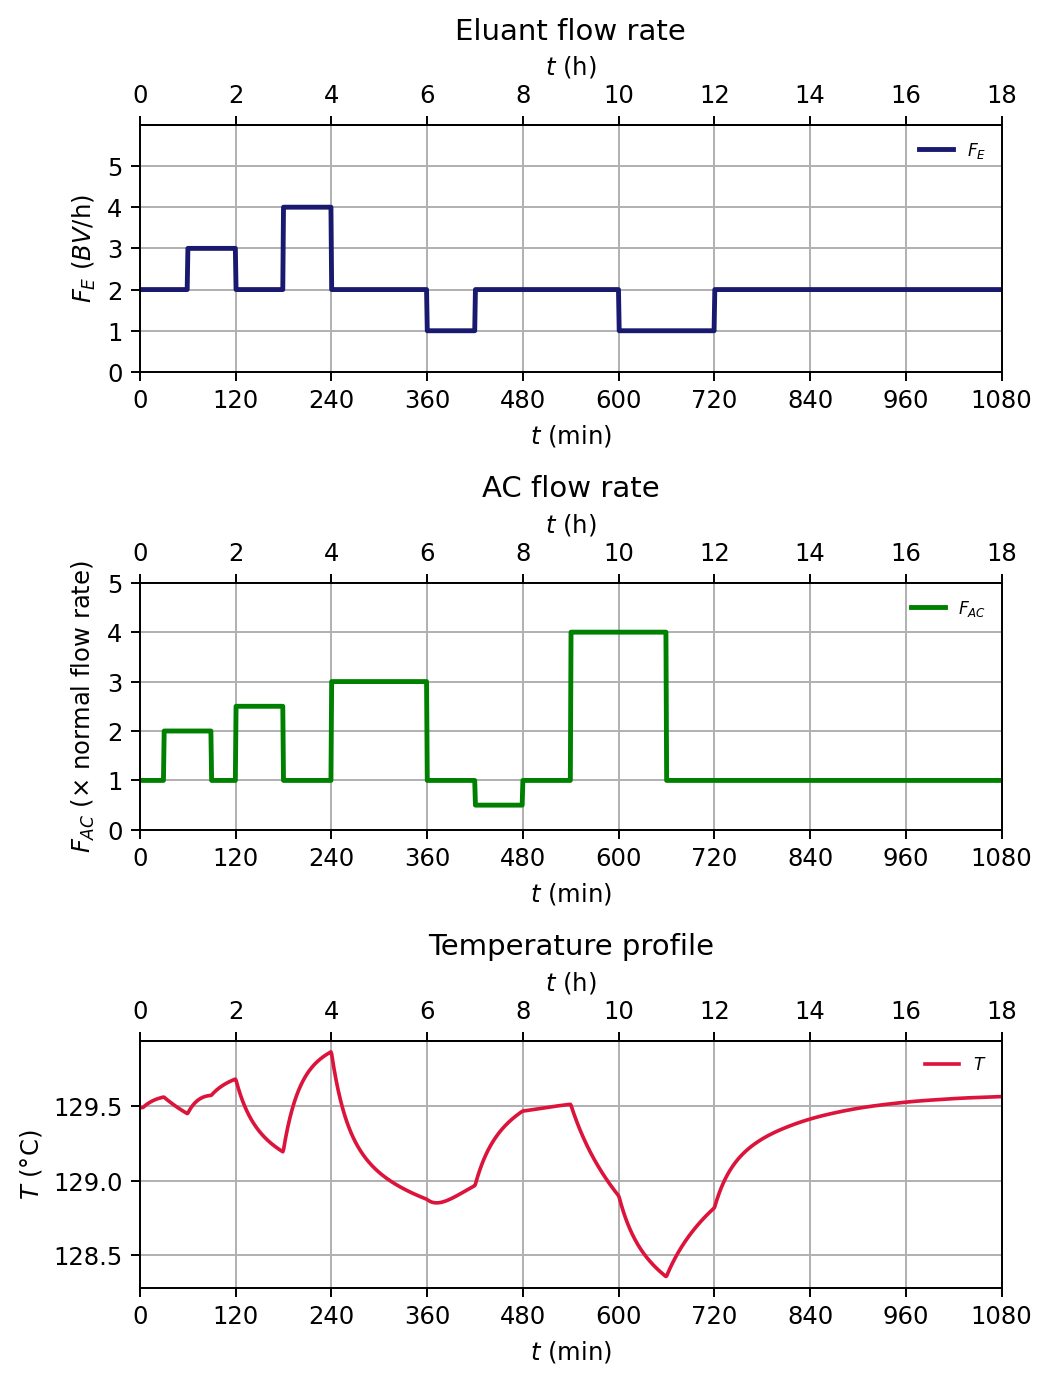

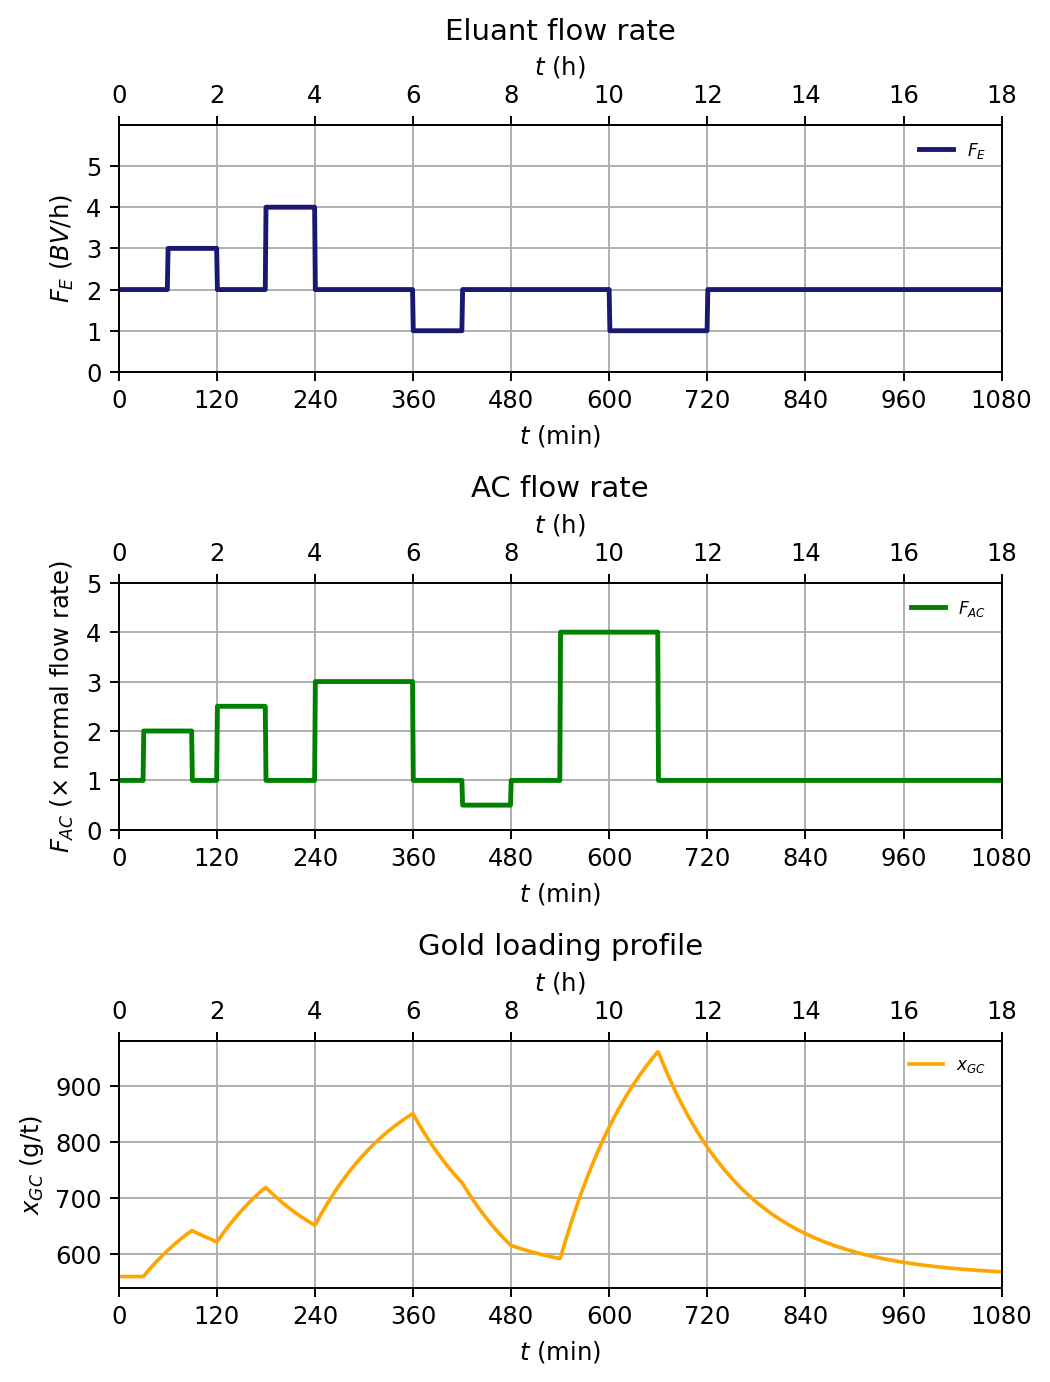

In [4]:
from scipy.signal import TransferFunction, lsim
import matplotlib.pyplot as plt
import numpy as np

########### Column and material properties ############

d = 1 # diameter (m)
h = 10*d # column height (m) 
A_cs = np.pi/4*d**2 # cross-sectional area (m^2)
h_outlet = 0.95*h # height until liquid outlet at the top (m)
V = A_cs*h_outlet # volume available to solid & liquid (m^3)
t_res = 18 # residence time (h)
epsilon = 0.292 # void fraction, 0.25 < epsilon < 0.50
BV_per_h = (1 - epsilon)*V/1 # m^3.h^-1
d_p = 1.82e-3 # particle diameter (m)
rho_AC = 838.8 # kg.m^-3
rho_E = 938.93 # kg.m^-3
cp_AC = 0.925 # kJ.kg^-1.K^-1
cp_E = 4.25 # kJ.kg^-1.K^-1
gamma = 1 # shape factor, spherical = 1
MW_G = 196.97 # g/mol

########### Known parameters #############
A = rho_AC*cp_AC
B = rho_E*cp_E
P = A/(A*(1 - epsilon)*V +B*epsilon*V) # m^-3
Q = B/(A*(1 - epsilon)*V +B*epsilon*V) # m^-3
R = 1/(A*(1 - epsilon)*V +B*epsilon*V) # K.kJ^-1
X = 6*(1 - epsilon)**2*V/d_p # m^2
Y = 1/((1 - epsilon)*V) # m^-3
Z = (1 - epsilon)/epsilon
T_AC_ss = 383.15 # K
T_E_ss = 403.15 # K
Delta_H_des = 7000 # kJ.mol^-1
K_des = 15.3
Gold_loading = 2500 # g/t

########### Calculated parameters #############
x_GCi = Gold_loading/1000
n_GCi = x_GCi/MW_G
C_GCi = n_GCi*rho_AC
F_AC = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
F_AC_ss = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
F_E = 2*BV_per_h/60 # BV.min^-1 or m^3.min^-1
F_E_ss = 2*BV_per_h/60 # BV.min^-1 or m^3.min^-1
F_e = F_E
k_L = 2e-7

T_ss = 402.6420 # K
C_GC_ss = 2.3813 # mol.m^-3

# Matrix coefficients

a_11 = -P*F_AC_ss - Q*F_E_ss # min^-1
a_12 = -X*R*k_L*K_des*Delta_H_des - X*R*Z*k_L*Delta_H_des # K.m^3.min^-1.mol^-1
a_21 = 0
a_22 = -Y*F_AC_ss - X*Y*k_L*K_des - X*Y*Z*k_L # min^-1

b_11 = Q*(T_E_ss - T_ss) # K.m^-3
b_12 = P*(T_AC_ss - T_ss) # K.m^-3
b_21 = 0
b_22 = Y*(C_GCi - C_GC_ss) # mol/m^-6

e_11 = Q*F_E_ss # min^-1
e_12 = P*F_AC_ss # min^-1
e_21 = 0
e_22 = 0

# Temperature loop parameters

tau_p1 = -1/a_11
K_p1 = -b_11/a_11
K_d11 = -a_12/a_11
K_d12 = -b_12/a_11
K_d13 = -e_11/a_11
K_d14 = -e_12/a_11

# Concentration loop parameters

tau_p2 = -1/a_22
K_p2 = -b_22/a_22

# Transfer functions for T'(s)

G_p1 = TransferFunction([K_p1], [tau_p1, 1])
G_d11 = TransferFunction([K_d11], [tau_p1, 1])
G_d12 = TransferFunction([K_d12], [tau_p1, 1])
G_d13 = TransferFunction([K_d13], [tau_p1, 1])
G_d14 = TransferFunction([K_d14], [tau_p1, 1])

# Transfer function for C_GC'(s)

G_p2 = TransferFunction([K_p2], [tau_p2, 1])

time = np.linspace(0, 1080, 1200)

# Input steps
U_BV = np.zeros(len(time))
BV = np.zeros(len(time))
U_AC = np.zeros(len(time))
AC_flow = np.zeros(len(time))
U_T_AC_dev = np.zeros(len(time))
U_T_E_dev = np.zeros(len(time))
p = 0
for t in time:
    U_T_AC_dev[p] = 0.1*np.sin(0.1*t) # Define sinusoidal variation for T_AC
    U_T_E_dev[5:] = 0.1*np.sin(0.1*t) # Define sinusoidal variation for T_E
    if t >= 60 and t < 120:
        U_BV[p] = 3*BV_per_h/60
        BV[p] = 3
    elif t >= 180 and t < 240:
        U_BV[p] = 4*BV_per_h/60
        BV[p] = 4
    elif t >= 360 and t < 420:
        U_BV[p] = 1*BV_per_h/60
        BV[p] = 1
    elif t >= 600 and t < 720:
        U_BV[p] = 1*BV_per_h/60
        BV[p] = 1
    else:
        U_BV[p] = 2*BV_per_h/60
        BV[p] = 2

    if t >= 30 and t < 90:
        U_AC[p] = 2*F_AC
        AC_flow[p] = 2
    elif t >= 120 and t < 180:
        U_AC[p] = 2.5*F_AC
        AC_flow[p] = 2.5
    elif t >= 240 and t < 360:
        U_AC[p] = 3*F_AC
        AC_flow[p] = 3
    elif t >= 420 and t < 480:
        U_AC[p] = 0.5*F_AC
        AC_flow[p] = 0.5
    elif t >= 540 and t < 660:
        U_AC[p] = 4*F_AC
        AC_flow[p] = 4 
    else:
        U_AC[p] = 1*F_AC
        AC_flow[p] = 1
    p += 1

# Put input variables into deviation form
U_AC_dev = U_AC - F_AC_ss
U_E_dev = U_BV - F_E_ss

# Simulate models

# Concentration needed first, because C_GC is disturbance in temperature loop
t, C_GC_p, x_p2 = lsim(G_p2, U = U_AC_dev, T = time)

U_C_GC_dev = C_GC_p 
# Still in deviation form. Add to C_GC_ss to get real C_GC
C_GC_ss = [C_GC_ss for i in range(len(time))]
C_GC = C_GC_p + C_GC_ss

n_GC_f = C_GC/rho_AC # mol Au/kg AC
x_GC_f = n_GC_f*MW_G*1000 # g Au/ton AC
C_GS = []

C_GS = (C_GCi-C_GC)*(1 - epsilon)/epsilon

t, T_p, x_p1 = lsim(G_p1, U = U_E_dev, T = time)
t, T_d1, x_d11 = lsim(G_d11, U = U_C_GC_dev, T = time)
t, T_d2, x_d12 = lsim(G_d12, U = U_AC_dev, T = time)
t, T_d3, x_d13 = lsim(G_d13, U = U_T_E_dev, T = time)
t, T_d4, x_d14 = lsim(G_d14, U = U_T_AC_dev, T = time)

# Add all contributions
T_dev = T_p + T_d1 + T_d2 + T_d3 + T_d4 

# Still in deviation form. Add to T_ss to get real T
T_ss = [T_ss for i in range(len(time))]
T = T_dev + T_ss
Kelvin_to_deg_C = [273.15 for i in range(len(time))]
T_celcius = T - Kelvin_to_deg_C

# Function to convert time scales for axes
def min_to_h(x):
    return x / 60

def h_to_min(x):
    return x * 60

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6.1, 8), dpi = 175)
fig.subplots_adjust(left = 2.5, right = 2.95)

# Eluant flow rate

ax1.plot(time, BV, color = 'midnightblue', label = r'$F_E$', lw = 2)
ax1.set_ylim([0, 6])
ax1.set_xlabel(r'$t$ (min)')
ax1.set_ylabel(r'$F_E\ (BV$/h)')
x_ticks = [q*120 for q in range(10)]
ax1.set_xticks(ticks = x_ticks)
y_ticks = [q for q in range(6)]
ax1.set_yticks(ticks = y_ticks)
ax1.set_xlim([0, 1080])
ax1.grid(True)
ax1.set_title('Eluant flow rate')
second_x1 = ax1.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x1.set_xticks(x_ticks_2nd)
second_x1.set_xlabel(r'$t$ (h)')
second_x1.set_xlim([0, 18])
ax1.legend(loc = 'upper right', frameon = False, fontsize = 7)

# AC flow rate

ax2.plot(time, AC_flow, color = 'green', label = r'$F_{AC}$', lw = 2)
ax2.set_xlabel(r'$t$ (min)')
ax2.set_ylabel(r'$F_{AC}$ ($\times$ normal flow rate)')
ax2.set_title('AC flow rate')
ax2.grid(True)
ax2.set_xticks(ticks = x_ticks)
ax2.set_xlim([0, 1080])
y_ticks = [q for q in range(6)]
ax2.set_yticks(ticks = y_ticks)
second_x2 = ax2.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x2.set_xticks(x_ticks_2nd)
second_x2.set_xlabel(r'$t$ (h)')
second_x2.set_xlim([0, 18])
ax2.legend(loc = 'upper right', frameon = False, fontsize = 7)

# Temperature

ax3.plot(time, T_celcius, color = 'crimson', label = r'$T$')
ax3.set_xlabel(r'$t$ (min)')
ax3.set_ylabel(r'$T$ ($\degree$C)')
ax3.grid(True)
ax3.set_xticks(ticks = x_ticks)
ax3.set_xlim([0, 1080])
ax3.set_title('Temperature profile')
second_x3 = ax3.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x3.set_xticks(x_ticks_2nd)
second_x3.set_xlabel(r'$t$ (h)')
second_x3.set_xlim([0, 18])
ax3.legend(loc = 'upper right', frameon = False, fontsize = 7)

plt.tight_layout()
plt.show()

# Gold on carbon

fig, (ax1, ax2, ax4) = plt.subplots(3, 1, figsize = (6.1, 8), dpi = 175)
fig.subplots_adjust(left = 2.5, right = 2.95)

ax1.plot(time, BV, color = 'midnightblue', label = r'$F_E$', lw = 2)
ax1.set_ylim([0, 6])
ax1.set_xlabel(r'$t$ (min)')
ax1.set_ylabel(r'$F_E\ (BV$/h)')
x_ticks = [q*120 for q in range(10)]
ax1.set_xticks(ticks = x_ticks)
y_ticks = [q for q in range(6)]
ax1.set_yticks(ticks = y_ticks)
ax1.set_xlim([0, 1080])
ax1.grid(True)
ax1.set_title('Eluant flow rate')
second_x1 = ax1.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x1.set_xticks(x_ticks_2nd)
second_x1.set_xlabel(r'$t$ (h)')
second_x1.set_xlim([0, 18])
ax1.legend(loc = 'upper right', frameon = False, fontsize = 7)

# AC flow rate

ax2.plot(time, AC_flow, color = 'green', label = r'$F_{AC}$', lw = 2)
ax2.set_xlabel(r'$t$ (min)')
ax2.set_ylabel(r'$F_{AC}$ ($\times$ normal flow rate)')
ax2.set_title('AC flow rate')
ax2.grid(True)
ax2.set_xticks(ticks = x_ticks)
ax2.set_xlim([0, 1080])
y_ticks = [q for q in range(6)]
ax2.set_yticks(ticks = y_ticks)
second_x2 = ax2.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x2.set_xticks(x_ticks_2nd)
second_x2.set_xlabel(r'$t$ (h)')
second_x2.set_xlim([0, 18])
ax2.legend(loc = 'upper right', frameon = False, fontsize = 7)

ax4.plot(time, x_GC_f, color = 'orange', label = r'$x_{GC}$')
ax4.set_xlabel(r'$t$ (min)')
ax4.set_ylabel(r'$x_{GC}$ (g/t)')
ax4.grid(True)
ax4.set_xticks(ticks = x_ticks)
ax4.set_xlim([0, 1080])
#y_ticks = [q*500 for q in range(6)]
#ax4.set_yticks(ticks = y_ticks)
ax4.set_title('Gold loading profile')
second_x4 = ax4.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x4.set_xticks(x_ticks_2nd)
second_x4.set_xlabel(r'$t$ (h)')
second_x4.set_xlim([0, 18])
ax4.legend(loc = 'upper right', frameon = False, fontsize = 7)

plt.tight_layout()
plt.show()

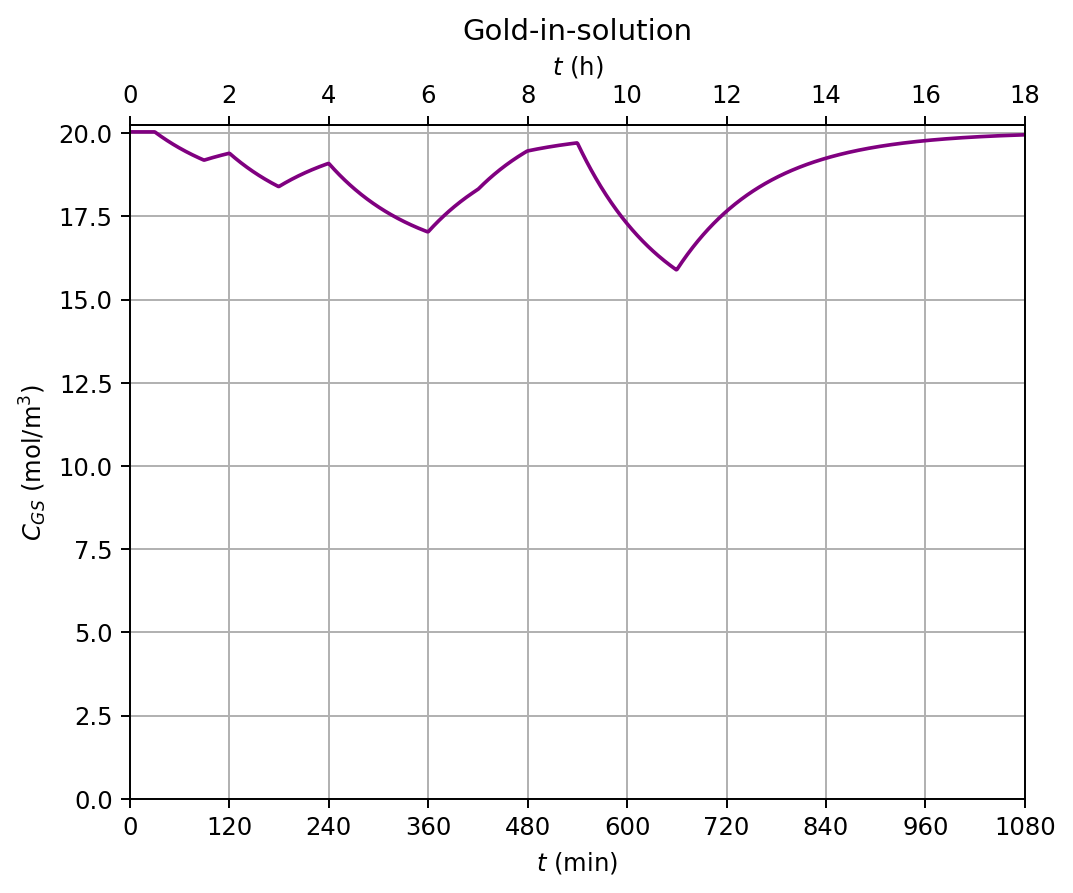

In [5]:
# Gold in solution

fig, ax5 = plt.subplots(figsize=(6.6, 5), dpi=175)
ax5.plot(time, C_GS, color = 'purple')
ax5.set_ylim(0)
ax5.set_xlim([0, 18])
ax5.set_xlabel(r'$t$ (min)')
ax5.set_ylabel(r'$C_{GS}$ (mol/m$^3$)')
x_ticks = [q*120 for q in range(10)]
ax5.set_xticks(ticks = x_ticks)

second_x = ax5.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2 = [q*2 for q in range(19)]
second_x.set_xticks(x_ticks_2)
second_x.set_xlabel(r'$t$ (h)')
second_x.set_xlim([0, 18])

ax5.grid(True)
ax5.set_title('Gold-in-solution')
plt.show()

# Isolated effect of eluant flow rate on $T$ and $x_{GC}$

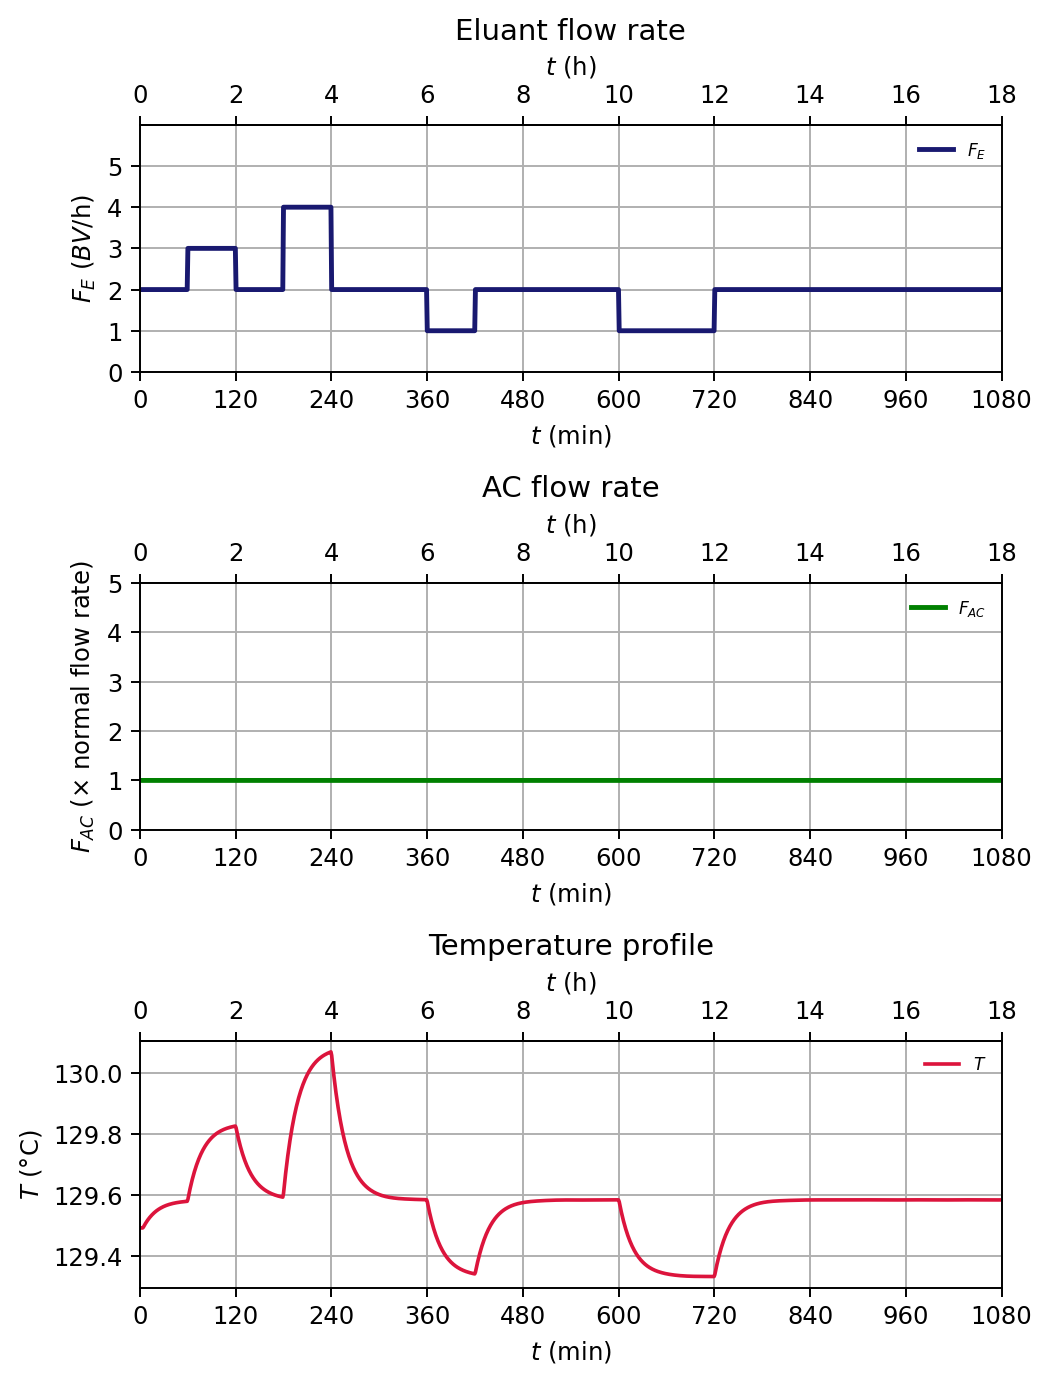

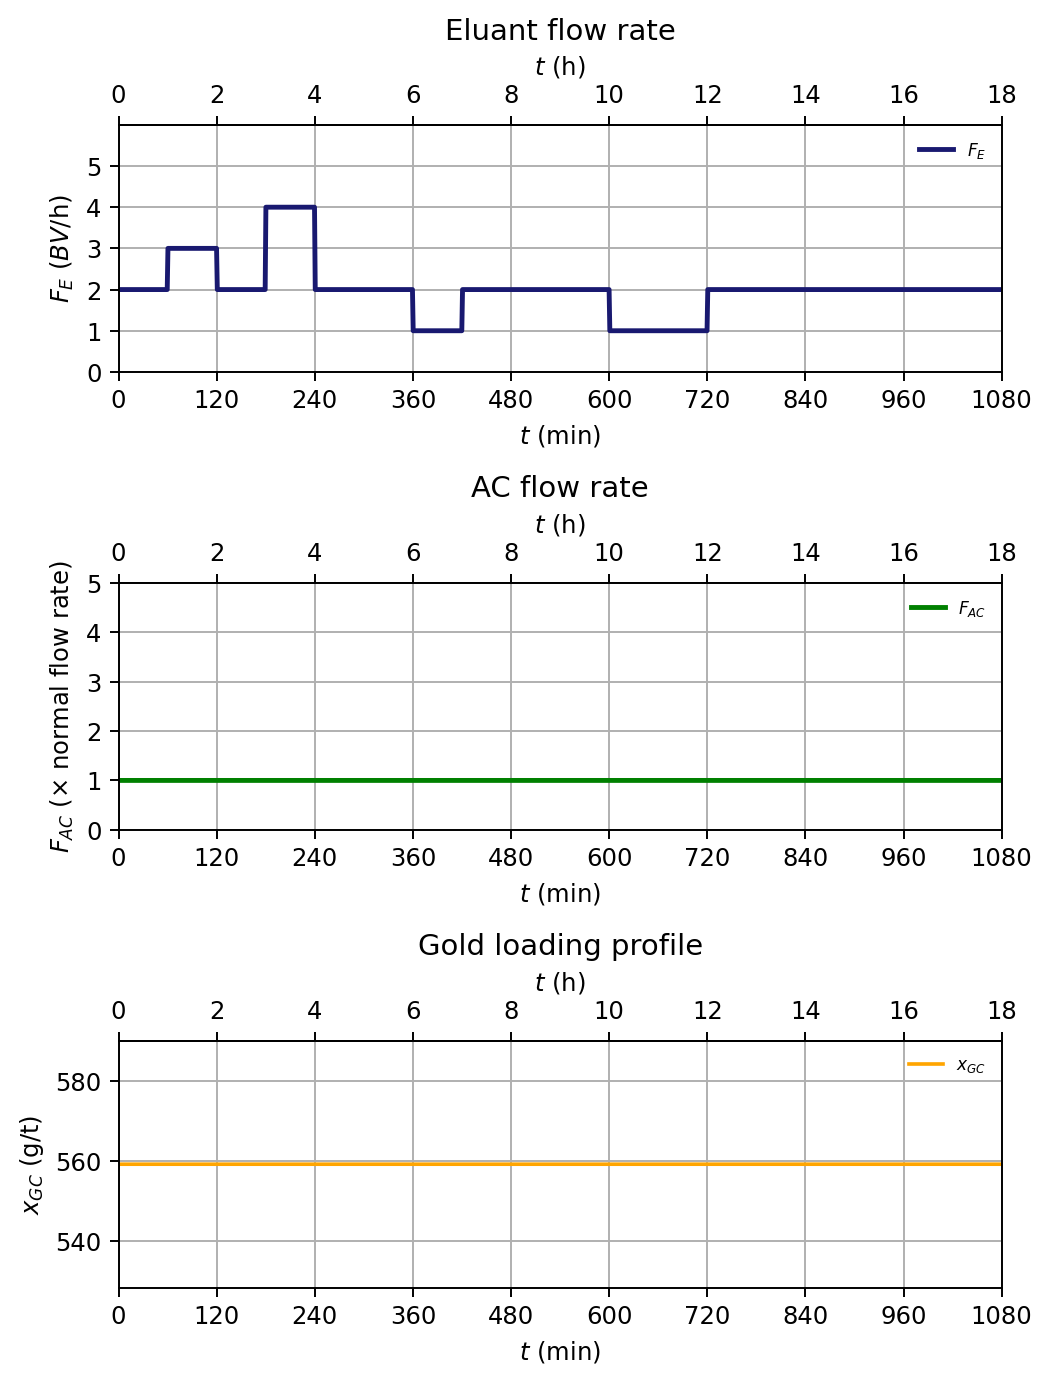

In [6]:
from scipy.signal import TransferFunction, lsim, step
import matplotlib.pyplot as plt
import numpy as np

########### Column and material properties ############

d = 1 # diameter (m)
h = 10*d # column height (m) 
A_cs = np.pi/4*d**2 # cross-sectional area (m^2)
h_outlet = 0.95*h # height until liquid outlet at the top (m)
V = A_cs*h_outlet # volume available to solid & liquid (m^3)
t_res = 18 # residence time (h)
epsilon = 0.292 # void fraction, 0.25 < epsilon < 0.50
BV_per_h = (1 - epsilon)*V/1 # m^3.h^-1
d_p = 1.82e-3 # particle diameter (m)
rho_AC = 838.8 # kg.m^-3
rho_E = 938.93 # kg.m^-3
cp_AC = 0.925 # kJ.kg^-1.K^-1
cp_E = 4.25 # kJ.kg^-1.K^-1
gamma = 1 # shape factor, spherical = 1
MW_G = 196.97 # g/mol

########### Known parameters #############
A = rho_AC*cp_AC
B = rho_E*cp_E
P = A/(A*(1 - epsilon)*V +B*epsilon*V) # m^-3
Q = B/(A*(1 - epsilon)*V +B*epsilon*V) # m^-3
R = 1/(A*(1 - epsilon)*V +B*epsilon*V) # K.kJ^-1
X = 6*(1 - epsilon)**2*V/d_p # m^2
Y = 1/((1 - epsilon)*V) # m^-3
Z = (1 - epsilon)/epsilon
T_AC_ss = 383.15 # K
T_E_ss = 403.15 # K
Delta_H_des = 7000 # kJ.mol^-1
K_des = 15.3
Gold_loading = 2500 # g/t

########### Calculated parameters #############
x_GCi = Gold_loading/1000
n_GCi = x_GCi/MW_G
C_GCi = n_GCi*rho_AC
F_AC = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
F_AC_ss = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
F_E = 2*BV_per_h/60 # BV.min^-1 or m^3.min^-1
F_E_ss = 2*BV_per_h/60 # BV.min^-1 or m^3.min^-1
F_e = F_E
k_L = 2e-7

T_ss = 402.6420 # K
C_GC_ss = 2.3813 # mol.m^-3

# Matrix coefficients

a_11 = -P*F_AC_ss - Q*F_E_ss # min^-1
a_12 = -X*R*k_L*K_des*Delta_H_des - X*R*Z*k_L*Delta_H_des # K.m^3.min^-1.mol^-1
a_21 = 0
a_22 = -Y*F_AC_ss - X*Y*k_L*K_des - X*Y*Z*k_L # min^-1

b_11 = Q*(T_E_ss - T_ss) # K.m^-3
b_12 = P*(T_AC_ss - T_ss) # K.m^-3
b_21 = 0
b_22 = Y*(C_GCi - C_GC_ss) # mol/m^-6

e_11 = Q*F_E_ss # min^-1
e_12 = P*F_AC_ss # min^-1
e_21 = 0
e_22 = 0

# Temperature loop parameters

tau_p1 = -1/a_11
K_p1 = -b_11/a_11
K_d11 = -a_12/a_11
K_d12 = -b_12/a_11
K_d13 = -e_11/a_11
K_d14 = -e_12/a_11

# Concentration loop parameters

tau_p2 = -1/a_22
K_p2 = -b_22/a_22

# Transfer functions for T'(s)

G_p1 = TransferFunction([K_p1], [tau_p1, 1])
G_d11 = TransferFunction([K_d11], [tau_p1, 1])
G_d12 = TransferFunction([K_d12], [tau_p1, 1])
G_d13 = TransferFunction([K_d13], [tau_p1, 1])
G_d14 = TransferFunction([K_d14], [tau_p1, 1])

# Transfer function for C_GC'(s)

G_p2 = TransferFunction([K_p2], [tau_p2, 1])

time = np.linspace(0, 1080, 1200)

# Input steps
U_BV = np.zeros(len(time))
BV = np.zeros(len(time))
U_AC = np.zeros(len(time))
AC_flow = np.zeros(len(time))
U_T_AC_dev = np.zeros(len(time))
U_T_E_dev = np.zeros(len(time))
p = 0
for t in time:
    U_T_AC_dev[p] = 0.1*np.sin(0.1*t) # Define sinusoidal variation for T_AC
    U_T_E_dev[5:] = 0.1*np.sin(0.1*t) # Define sinusoidal variation for T_E
    if t >= 60 and t < 120:
        U_BV[p] = 3*BV_per_h/60
        BV[p] = 3
    elif t >= 180 and t < 240:
        U_BV[p] = 4*BV_per_h/60
        BV[p] = 4
    elif t >= 360 and t < 420:
        U_BV[p] = 1*BV_per_h/60
        BV[p] = 1
    elif t >= 600 and t < 720:
        U_BV[p] = 1*BV_per_h/60
        BV[p] = 1
    else:
        U_BV[p] = 2*BV_per_h/60
        BV[p] = 2

    # Isolate effect of eluant flow rate; therefore, F_AC kept constant at 1*normal flow rate
    U_AC[p] = 1*F_AC
    AC_flow[p] = 1
    p += 1

# Put input variables into deviation form
U_AC_dev = U_AC - F_AC_ss
U_E_dev = U_BV - F_E_ss

# Simulate models

# Concentration needed first, because C_GC is disturbance in temperature loop
t, C_GC_p, x_p2 = lsim(G_p2, U = U_AC_dev, T = time)

U_C_GC_dev = C_GC_p 
# Still in deviation form. Add to C_GC_ss to get real C_GC
C_GC_ss = [C_GC_ss for i in range(len(time))]
C_GC = C_GC_p + C_GC_ss

n_GC_f = C_GC/rho_AC # mol Au/kg AC
x_GC_f = n_GC_f*MW_G*1000 # g Au/ton AC
C_GS = []

C_GS = (C_GCi-C_GC)*(1 - epsilon)/epsilon

t, T_p, x_p1 = lsim(G_p1, U = U_E_dev, T = time)
t, T_d1, x_d11 = lsim(G_d11, U = U_C_GC_dev, T = time)
t, T_d2, x_d12 = lsim(G_d12, U = U_AC_dev, T = time)
t, T_d3, x_d13 = lsim(G_d13, U = U_T_E_dev, T = time)
t, T_d4, x_d14 = lsim(G_d14, U = U_T_AC_dev, T = time)

# Add all contributions
T_dev = T_p + T_d1 + T_d2 + T_d3 + T_d4 

# Still in deviation form. Add to T_ss to get real T
T_ss = [T_ss for i in range(len(time))]
T = T_dev + T_ss
Kelvin_to_deg_C = [273.15 for i in range(len(time))]
T_celcius = T - Kelvin_to_deg_C

# Function to convert time scales for axes
def min_to_h(x):
    return x / 60

def h_to_min(x):
    return x * 60

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6.1, 8), dpi = 175)
fig.subplots_adjust(left = 2.5, right = 2.95)

# Eluant flow rate

ax1.plot(time, BV, color = 'midnightblue', label = r'$F_E$', lw = 2)
ax1.set_ylim([0, 6])
ax1.set_xlabel(r'$t$ (min)')
ax1.set_ylabel(r'$F_E\ (BV$/h)')
x_ticks = [q*120 for q in range(10)]
ax1.set_xticks(ticks = x_ticks)
y_ticks = [q for q in range(6)]
ax1.set_yticks(ticks = y_ticks)
ax1.set_xlim([0, 1080])
ax1.grid(True)
ax1.set_title('Eluant flow rate')
second_x1 = ax1.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x1.set_xticks(x_ticks_2nd)
second_x1.set_xlabel(r'$t$ (h)')
second_x1.set_xlim([0, 18])
ax1.legend(loc = 'upper right', frameon = False, fontsize = 7)

# AC flow rate

ax2.plot(time, AC_flow, color = 'green', label = r'$F_{AC}$', lw = 2)
ax2.set_xlabel(r'$t$ (min)')
ax2.set_ylabel(r'$F_{AC}$ ($\times$ normal flow rate)')
ax2.set_title('AC flow rate')
ax2.grid(True)
ax2.set_xticks(ticks = x_ticks)
ax2.set_xlim([0, 1080])
y_ticks = [q for q in range(6)]
ax2.set_yticks(ticks = y_ticks)
second_x2 = ax2.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x2.set_xticks(x_ticks_2nd)
second_x2.set_xlabel(r'$t$ (h)')
second_x2.set_xlim([0, 18])
ax2.legend(loc = 'upper right', frameon = False, fontsize = 7)

# Temperature

ax3.plot(time, T_celcius, color = 'crimson', label = r'$T$')
ax3.set_xlabel(r'$t$ (min)')
ax3.set_ylabel(r'$T$ ($\degree$C)')
ax3.grid(True)
ax3.set_xticks(ticks = x_ticks)
ax3.set_xlim([0, 1080])
ax3.set_title('Temperature profile')
second_x3 = ax3.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x3.set_xticks(x_ticks_2nd)
second_x3.set_xlabel(r'$t$ (h)')
second_x3.set_xlim([0, 18])
ax3.legend(loc = 'upper right', frameon = False, fontsize = 7)

plt.tight_layout()
plt.show()

# Gold on carbon

fig, (ax1, ax2, ax4) = plt.subplots(3, 1, figsize = (6.1, 8), dpi = 175)
fig.subplots_adjust(left = 2.5, right = 2.95)

ax1.plot(time, BV, color = 'midnightblue', label = r'$F_E$', lw = 2)
ax1.set_ylim([0, 6])
ax1.set_xlabel(r'$t$ (min)')
ax1.set_ylabel(r'$F_E\ (BV$/h)')
x_ticks = [q*120 for q in range(10)]
ax1.set_xticks(ticks = x_ticks)
y_ticks = [q for q in range(6)]
ax1.set_yticks(ticks = y_ticks)
ax1.set_xlim([0, 1080])
ax1.grid(True)
ax1.set_title('Eluant flow rate')
second_x1 = ax1.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x1.set_xticks(x_ticks_2nd)
second_x1.set_xlabel(r'$t$ (h)')
second_x1.set_xlim([0, 18])
ax1.legend(loc = 'upper right', frameon = False, fontsize = 7)

# AC flow rate

ax2.plot(time, AC_flow, color = 'green', label = r'$F_{AC}$', lw = 2)
ax2.set_xlabel(r'$t$ (min)')
ax2.set_ylabel(r'$F_{AC}$ ($\times$ normal flow rate)')
ax2.set_title('AC flow rate')
ax2.grid(True)
ax2.set_xticks(ticks = x_ticks)
ax2.set_xlim([0, 1080])
y_ticks = [q for q in range(6)]
ax2.set_yticks(ticks = y_ticks)
second_x2 = ax2.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x2.set_xticks(x_ticks_2nd)
second_x2.set_xlabel(r'$t$ (h)')
second_x2.set_xlim([0, 18])
ax2.legend(loc = 'upper right', frameon = False, fontsize = 7)

ax4.plot(time, x_GC_f, color = 'orange', label = r'$x_{GC}$')
ax4.set_xlabel(r'$t$ (min)')
ax4.set_ylabel(r'$x_{GC}$ (g/t)')
ax4.grid(True)
ax4.set_xticks(ticks = x_ticks)
ax4.set_xlim([0, 1080])
#y_ticks = [q*500 for q in range(6)]
#ax4.set_yticks(ticks = y_ticks)
ax4.set_title('Gold loading profile')
second_x4 = ax4.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x4.set_xticks(x_ticks_2nd)
second_x4.set_xlabel(r'$t$ (h)')
second_x4.set_xlim([0, 18])
ax4.legend(loc = 'upper right', frameon = False, fontsize = 7)

plt.tight_layout()
plt.show()

# Isolated effect of AC flow rate on $T$ and $x_{GC}$

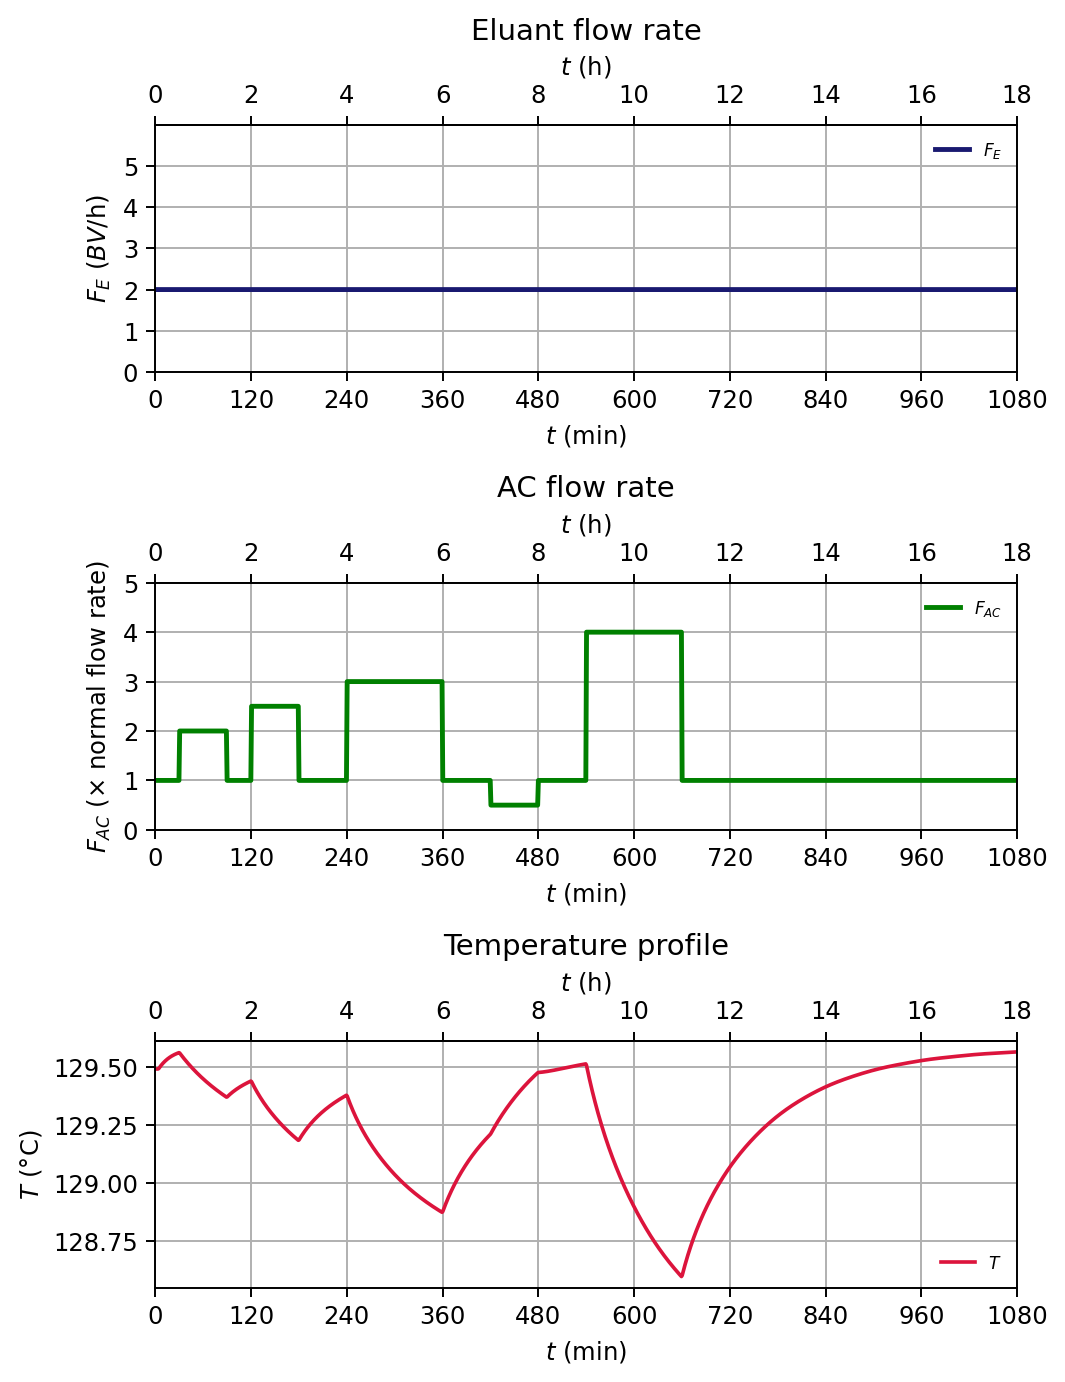

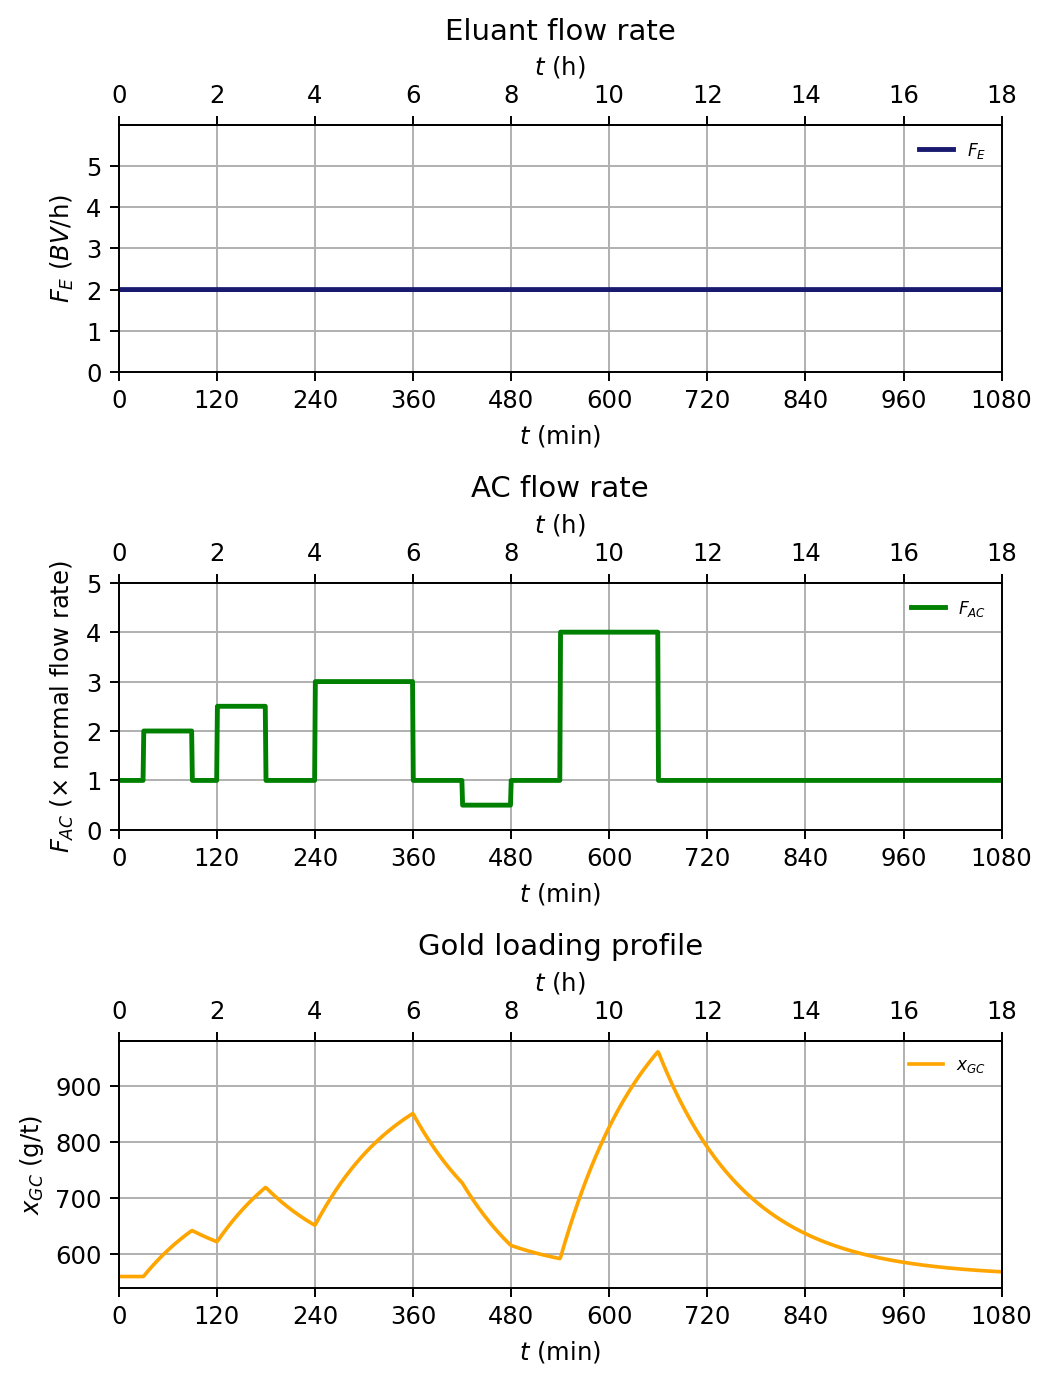

In [7]:
from scipy.signal import TransferFunction, lsim, step
import matplotlib.pyplot as plt
import numpy as np

########### Column and material properties ############

d = 1 # diameter (m)
h = 10*d # column height (m) 
A_cs = np.pi/4*d**2 # cross-sectional area (m^2)
h_outlet = 0.95*h # height until liquid outlet at the top (m)
V = A_cs*h_outlet # volume available to solid & liquid (m^3)
t_res = 18 # residence time (h)
epsilon = 0.292 # void fraction, 0.25 < epsilon < 0.50
BV_per_h = (1 - epsilon)*V/1 # m^3.h^-1
d_p = 1.82e-3 # particle diameter (m)
rho_AC = 838.8 # kg.m^-3
rho_E = 938.93 # kg.m^-3
cp_AC = 0.925 # kJ.kg^-1.K^-1
cp_E = 4.25 # kJ.kg^-1.K^-1
gamma = 1 # shape factor, spherical = 1
MW_G = 196.97 # g/mol

########### Known parameters #############
A = rho_AC*cp_AC
B = rho_E*cp_E
P = A/(A*(1 - epsilon)*V +B*epsilon*V) # m^-3
Q = B/(A*(1 - epsilon)*V +B*epsilon*V) # m^-3
R = 1/(A*(1 - epsilon)*V +B*epsilon*V) # K.kJ^-1
X = 6*(1 - epsilon)**2*V/d_p # m^2
Y = 1/((1 - epsilon)*V) # m^-3
Z = (1 - epsilon)/epsilon
T_AC_ss = 383.15 # K
T_E_ss = 403.15 # K
Delta_H_des = 7000 # kJ.mol^-1
K_des = 15.3
Gold_loading = 2500 # g/t

########### Calculated parameters #############
x_GCi = Gold_loading/1000
n_GCi = x_GCi/MW_G
C_GCi = n_GCi*rho_AC
F_AC = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
F_AC_ss = (1 - epsilon)*V/(t_res*60) # m^3.min^-1
F_E = 2*BV_per_h/60 # BV.min^-1 or m^3.min^-1
F_E_ss = 2*BV_per_h/60 # BV.min^-1 or m^3.min^-1
F_e = F_E
k_L = 2e-7

T_ss = 402.6420 # K
C_GC_ss = 2.3813 # mol.m^-3

# Matrix coefficients

a_11 = -P*F_AC_ss - Q*F_E_ss # min^-1
a_12 = -X*R*k_L*K_des*Delta_H_des - X*R*Z*k_L*Delta_H_des # K.m^3.min^-1.mol^-1
a_21 = 0
a_22 = -Y*F_AC_ss - X*Y*k_L*K_des - X*Y*Z*k_L # min^-1

b_11 = Q*(T_E_ss - T_ss) # K.m^-3
b_12 = P*(T_AC_ss - T_ss) # K.m^-3
b_21 = 0
b_22 = Y*(C_GCi - C_GC_ss) # mol/m^-6

e_11 = Q*F_E_ss # min^-1
e_12 = P*F_AC_ss # min^-1
e_21 = 0
e_22 = 0

# Temperature loop parameters

tau_p1 = -1/a_11
K_p1 = -b_11/a_11
K_d11 = -a_12/a_11
K_d12 = -b_12/a_11
K_d13 = -e_11/a_11
K_d14 = -e_12/a_11

# Concentration loop parameters

tau_p2 = -1/a_22
K_p2 = -b_22/a_22

# Transfer functions for T'(s)

G_p1 = TransferFunction([K_p1], [tau_p1, 1])
G_d11 = TransferFunction([K_d11], [tau_p1, 1])
G_d12 = TransferFunction([K_d12], [tau_p1, 1])
G_d13 = TransferFunction([K_d13], [tau_p1, 1])
G_d14 = TransferFunction([K_d14], [tau_p1, 1])

# Transfer function for C_GC'(s)

G_p2 = TransferFunction([K_p2], [tau_p2, 1])

time = np.linspace(0, 1080, 1200)

# Input steps
U_BV = np.zeros(len(time))
BV = np.zeros(len(time))
U_AC = np.zeros(len(time))
AC_flow = np.zeros(len(time))
U_T_AC_dev = np.zeros(len(time))
U_T_E_dev = np.zeros(len(time))
p = 0
for t in time:
    U_T_AC_dev[p] = 0.1*np.sin(0.1*t) # Define sinusoidal variation for T_AC
    U_T_E_dev[5:] = 0.1*np.sin(0.1*t) # Define sinusoidal variation for T_E

    # Isolate effect of AC flow rate; therefore, F_E is constant at 2*BV/h
    U_BV[p] = 2*BV_per_h/60
    BV[p] = 2

    if t >= 30 and t < 90:
        U_AC[p] = 2*F_AC
        AC_flow[p] = 2
    elif t >= 120 and t < 180:
        U_AC[p] = 2.5*F_AC
        AC_flow[p] = 2.5
    elif t >= 240 and t < 360:
        U_AC[p] = 3*F_AC
        AC_flow[p] = 3
    elif t >= 420 and t < 480:
        U_AC[p] = 0.5*F_AC
        AC_flow[p] = 0.5
    elif t >= 540 and t < 660:
        U_AC[p] = 4*F_AC
        AC_flow[p] = 4 
    else:
        U_AC[p] = 1*F_AC
        AC_flow[p] = 1
    p += 1

# Put input variables into deviation form
U_AC_dev = U_AC - F_AC_ss
U_E_dev = U_BV - F_E_ss

# Simulate models

# Concentration needed first, because C_GC is disturbance in temperature loop
t, C_GC_p, x_p2 = lsim(G_p2, U = U_AC_dev, T = time)

U_C_GC_dev = C_GC_p 
# Still in deviation form. Add to C_GC_ss to get real C_GC
C_GC_ss = [C_GC_ss for i in range(len(time))]
C_GC = C_GC_p + C_GC_ss

n_GC_f = C_GC/rho_AC # mol Au/kg AC
x_GC_f = n_GC_f*MW_G*1000 # g Au/ton AC
C_GS = []

C_GS = (C_GCi-C_GC)*(1 - epsilon)/epsilon

t, T_p, x_p1 = lsim(G_p1, U = U_E_dev, T = time)
t, T_d1, x_d11 = lsim(G_d11, U = U_C_GC_dev, T = time)
t, T_d2, x_d12 = lsim(G_d12, U = U_AC_dev, T = time)
t, T_d3, x_d13 = lsim(G_d13, U = U_T_E_dev, T = time)
t, T_d4, x_d14 = lsim(G_d14, U = U_T_AC_dev, T = time)

# Add all contributions
T_dev = T_p + T_d1 + T_d2 + T_d3 + T_d4 

# Still in deviation form. Add to T_ss to get real T
T_ss = [T_ss for i in range(len(time))]
T = T_dev + T_ss
Kelvin_to_deg_C = [273.15 for i in range(len(time))]
T_celcius = T - Kelvin_to_deg_C

# Function to convert time scales for axes
def min_to_h(x):
    return x / 60

def h_to_min(x):
    return x * 60

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6.1, 8), dpi = 175)
fig.subplots_adjust(left = 2.5, right = 2.95)

# Eluant flow rate

ax1.plot(time, BV, color = 'midnightblue', label = r'$F_E$', lw = 2)
ax1.set_ylim([0, 6])
ax1.set_xlabel(r'$t$ (min)')
ax1.set_ylabel(r'$F_E\ (BV$/h)')
x_ticks = [q*120 for q in range(10)]
ax1.set_xticks(ticks = x_ticks)
y_ticks = [q for q in range(6)]
ax1.set_yticks(ticks = y_ticks)
ax1.set_xlim([0, 1080])
ax1.grid(True)
ax1.set_title('Eluant flow rate')
second_x1 = ax1.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x1.set_xticks(x_ticks_2nd)
second_x1.set_xlabel(r'$t$ (h)')
second_x1.set_xlim([0, 18])
ax1.legend(loc = 'upper right', frameon = False, fontsize = 7)

# AC flow rate

ax2.plot(time, AC_flow, color = 'green', label = r'$F_{AC}$', lw = 2)
ax2.set_xlabel(r'$t$ (min)')
ax2.set_ylabel(r'$F_{AC}$ ($\times$ normal flow rate)')
ax2.set_title('AC flow rate')
ax2.grid(True)
ax2.set_xticks(ticks = x_ticks)
ax2.set_xlim([0, 1080])
y_ticks = [q for q in range(6)]
ax2.set_yticks(ticks = y_ticks)
second_x2 = ax2.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x2.set_xticks(x_ticks_2nd)
second_x2.set_xlabel(r'$t$ (h)')
second_x2.set_xlim([0, 18])
ax2.legend(loc = 'upper right', frameon = False, fontsize = 7)

# Temperature

ax3.plot(time, T_celcius, color = 'crimson', label = r'$T$')
ax3.set_xlabel(r'$t$ (min)')
ax3.set_ylabel(r'$T$ ($\degree$C)')
ax3.grid(True)
ax3.set_xticks(ticks = x_ticks)
ax3.set_xlim([0, 1080])
ax3.set_title('Temperature profile')
second_x3 = ax3.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x3.set_xticks(x_ticks_2nd)
second_x3.set_xlabel(r'$t$ (h)')
second_x3.set_xlim([0, 18])
ax3.legend(loc = 'lower right', frameon = False, fontsize = 7)

plt.tight_layout()
plt.show()

# Gold on carbon

fig, (ax1, ax2, ax4) = plt.subplots(3, 1, figsize = (6.1, 8), dpi = 175)
fig.subplots_adjust(left = 2.5, right = 2.95)

ax1.plot(time, BV, color = 'midnightblue', label = r'$F_E$', lw = 2)
ax1.set_ylim([0, 6])
ax1.set_xlabel(r'$t$ (min)')
ax1.set_ylabel(r'$F_E\ (BV$/h)')
x_ticks = [q*120 for q in range(10)]
ax1.set_xticks(ticks = x_ticks)
y_ticks = [q for q in range(6)]
ax1.set_yticks(ticks = y_ticks)
ax1.set_xlim([0, 1080])
ax1.grid(True)
ax1.set_title('Eluant flow rate')
second_x1 = ax1.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x1.set_xticks(x_ticks_2nd)
second_x1.set_xlabel(r'$t$ (h)')
second_x1.set_xlim([0, 18])
ax1.legend(loc = 'upper right', frameon = False, fontsize = 7)

# AC flow rate

ax2.plot(time, AC_flow, color = 'green', label = r'$F_{AC}$', lw = 2)
ax2.set_xlabel(r'$t$ (min)')
ax2.set_ylabel(r'$F_{AC}$ ($\times$ normal flow rate)')
ax2.set_title('AC flow rate')
ax2.grid(True)
ax2.set_xticks(ticks = x_ticks)
ax2.set_xlim([0, 1080])
y_ticks = [q for q in range(6)]
ax2.set_yticks(ticks = y_ticks)
second_x2 = ax2.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x2.set_xticks(x_ticks_2nd)
second_x2.set_xlabel(r'$t$ (h)')
second_x2.set_xlim([0, 18])
ax2.legend(loc = 'upper right', frameon = False, fontsize = 7)

ax4.plot(time, x_GC_f, color = 'orange', label = r'$x_{GC}$')
ax4.set_xlabel(r'$t$ (min)')
ax4.set_ylabel(r'$x_{GC}$ (g/t)')
ax4.grid(True)
ax4.set_xticks(ticks = x_ticks)
ax4.set_xlim([0, 1080])
#y_ticks = [q*500 for q in range(6)]
#ax4.set_yticks(ticks = y_ticks)
ax4.set_title('Gold loading profile')
second_x4 = ax4.secondary_xaxis('top', functions=(min_to_h, h_to_min))
x_ticks_2nd = [q*2 for q in range(19)]
second_x4.set_xticks(x_ticks_2nd)
second_x4.set_xlabel(r'$t$ (h)')
second_x4.set_xlim([0, 18])
ax4.legend(loc = 'upper right', frameon = False, fontsize = 7)

plt.tight_layout()
plt.show()